## import libraries 

In [1]:
import pandas
import configparser
import psycopg2

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

host = config['myaws']['host']
db = config['myaws']['db']
user = config['myaws']['user']
pwd = config['myaws']['pwd']

In [3]:
conn = psycopg2.connect(host = host,
                       user = user,
                        password = pwd,
                        dbname = db
                       )
cur = conn.cursor()

## create the hosue table

In [4]:


# replace the schema and table name to your schema and table name
table_sql = """
            CREATE TABLE IF NOT EXISTS gp29.house
            (

                price integer,
                bed integer,
                bath integer,
                area integer,
                address VARCHAR(200),
                PRIMARY KEY(address)
            );

            """



In [117]:
#conn.rollback()
#table_sql="drop table if exists demo.house"

In [5]:

cur.execute(table_sql)
conn.commit()

## define the search region

In [6]:
url = 'https://www.trulia.com/VA/McLean/22101/'

In [8]:


import urllib.request
response = urllib.request.urlopen(url)
html_data= response.read()
#print(html_data.decode('utf-8'))



In [10]:


from bs4 import BeautifulSoup
soup = BeautifulSoup(html_data,'html.parser')
#print (soup)



## insert the records into database

In [11]:

for li_class in soup.find_all('li', class_ = 'Grid__CellBox-sc-144isrp-0 SearchResultsList__WideCell-b7y9ki-2 jiZmPM'):
    try:
        for price_div in li_class.find_all('div',{'data-testid':'property-price'}):
            price =int(price_div.text.replace('$','').replace(",",""))
        for bed_div in li_class.find_all('div', {'data-testid':'property-beds'}):
            bed= int(bed_div.text.replace('bd','').replace(",",""))
        for bath_div in li_class.find_all('div',{'data-testid':'property-baths'}):
            bath =int(bath_div.text.replace('ba','').replace(",",""))
        for area_div in li_class.find_all('div',{'data-testid':'property-floorSpace'}):
            area=int(area_div.text.split('sqft')[0].replace(",",""))
        for address_div in li_class.find_all('div',{'data-testid':'property-address'}):
            address =address_div.text

        try:
            sql_insert = """
                        insert into gp29.house(price,bed,bath,area,address)
                        values('{}','{}','{}','{}','{}')            
                        """.format(price,bed,bath,area,address)

            cur.execute(sql_insert)
            conn.commit()
        except:
            conn.rollback()
    except:
        pass
        

## Query the Table

In [13]:
df = pandas.read_sql_query('select * from gp29.house ', conn)
df[:10]

,price,bed,bath,area,address
0,979900,4,4,2652,"1229 Kensington Rd, Mclean, VA 22101"
1,850000,4,4,2380,"6704 Melrose Dr, Mclean, VA 22101"
2,775000,2,3,1226,"6719 Churchill Rd, Mclean, VA 22101"
3,24000000,8,13,20000,"1171 Chain Bridge Rd, Mclean, VA 22101"
4,1499000,4,4,2389,"1326 Kirby Rd, Mclean, VA 22101"
5,10497000,6,6,12606,"620 Rivercrest Dr, Mclean, VA 22101"
6,8500000,6,9,10178,"1306 Ballantrae Ct, Mclean, VA 22101"
7,11998000,5,11,16000,"612 Rivercrest Dr, Mclean, VA 22101"
8,6250000,5,6,6340,"1217 Crest Ln, Mclean, VA 22101"
9,7950000,6,10,13722,"1332 McCay Ln, Mclean, VA 22101"


## basic stat

In [14]:
df.describe()

,price,bed,bath,area
count,4.000000e+01,40.000000,40.000000,40.000000
mean,4.829790e+06,5.150000,6.650000,7499.175000
std,5.036449e+06,1.641606,3.206964,5547.670104
min,7.499000e+05,2.000000,2.000000,1226.000000
25%,1.099750e+06,4.000000,4.000000,2476.750000
50%,2.384944e+06,5.000000,6.000000,6253.000000
75%,7.237499e+06,6.000000,9.000000,12418.250000
max,2.400000e+07,9.000000,13.000000,20000.000000


## price distribution

<AxesSubplot:>

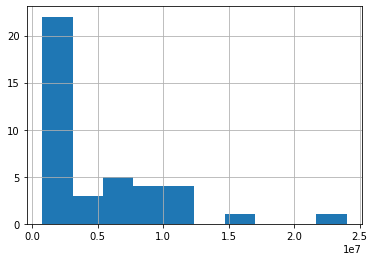

In [15]:
df['price'].hist()

## bed vs bath

<AxesSubplot:xlabel='bed', ylabel='bath'>

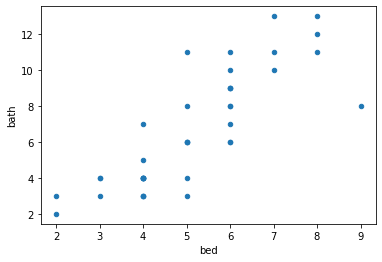

In [16]:
df.plot.scatter(x='bed',y='bath')